# KNN and A Standard Pipeline 

In this document we showcase how a standard feature manufacturing and selecting pipeline works, and investigate into cv loop of KNN. 

In [173]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import f_classif
import itertools
import sys
import importlib
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, make_scorer
from joblib import Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits
import matplotlib.pylab as plt
import os
from sklearn.inspection import permutation_importance

sys.path.append("../")
from proj_mod import training
importlib.reload(training);

To ensure that there is no data leakage, the pipeline has to be fully automatic in evaluating the data, ranking importance, feature manufacturing, and finally, produce the model all ONLY on the train set. 

In [53]:
df=pd.read_csv("../data/raw.csv")
features=list(df.columns)[1:]
target=["Y"]
feat=df[features]
tar=df[target]
x_t, x_v, y_t, y_v= train_test_split(feat,tar, test_size=0.2, random_state=0, stratify=tar["Y"])
n_splits=5

## Evaluating data

With the input, we first analysis with Anova F test to rank importance of the raw features. 

In [10]:
f_score, p_value = f_classif(X=x_t,y=y_t["Y"])
df_f=pd.DataFrame(({"features":x_t.columns, 
                    "f score": f_score, 
                    "p value": p_value}))
df_f.sort_values(by=["f score"], ascending=False)

,features,f score,p value
0,X1,9.859455,0.002233
4,X5,4.947507,0.028423
5,X6,3.708349,0.057039
2,X3,1.225000,0.271091
3,X4,0.258824,0.612073
1,X2,0.160949,0.689158


## Feature manufacturing 

In [13]:
x_t_copy=x_t.copy(deep=True)
x_t_copy["mean"]=x_t_copy[features].mean(axis=1)
x_t_copy["F_w_mean"]=x_t_copy[features].apply(lambda row_arr: (np.array(row_arr)* f_classif(X=x_t_copy[features],y=y_t["Y"])[0]).mean(), axis=1)
# x_t_copy["mi_w_mean"]=x_t_copy[features].apply(lambda row_arr: (np.array(row_arr)*mutual_info_classif(X=df2[features],y=df2["Y"],discrete_features=True)).sum()/len(features), axis=1)
x_t_copy["above_3"]=x_t_copy[features].apply(lambda row_arr: (row_arr >= 3).mean(), axis=1)
x_t_copy["above_4"]=x_t_copy[features].apply(lambda row_arr: (row_arr >= 4).mean(), axis=1)
x_t_copy["above_5"]=x_t_copy[features].apply(lambda row_arr: (row_arr >= 5).mean(), axis=1)

In [14]:
x_t_copy

,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5
28,3,3,1,3,3,4,2.833333,10.289766,0.833333,0.166667,0.000000
46,5,3,3,4,4,5,4.000000,15.470365,1.000000,0.666667,0.333333
67,4,1,1,3,4,4,2.833333,12.703944,0.666667,0.500000,0.000000
3,5,4,3,3,3,5,3.833333,14.629468,1.000000,0.500000,0.333333
27,3,3,1,3,3,4,2.833333,10.289766,0.833333,0.166667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
57,4,4,4,4,3,4,3.833333,12.615471,1.000000,0.833333,0.000000
39,4,4,3,4,2,4,3.500000,11.586720,0.833333,0.666667,0.000000
94,3,1,3,2,1,2,2.000000,7.716028,0.333333,0.000000,0.000000
53,5,2,4,3,4,5,3.833333,15.604569,0.833333,0.666667,0.333333


## Ranking importance with consideration of colinearity 

In [29]:
total=x_t_copy.copy(deep=True)
total["Y"]=y_t["Y"]
total_corr=total.corr()
total_corr

,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
X1,1.000000,0.003575,0.197993,0.033369,0.337179,0.376458,0.528688,0.841993,0.139387,0.443484,0.590197,0.302341
X2,0.003575,1.000000,0.202463,0.054034,0.009242,-0.087204,0.413327,0.019487,0.466674,0.276085,0.190669,-0.040493
X3,0.197993,0.202463,1.000000,0.282279,0.296808,0.186113,0.664461,0.393921,0.382278,0.612709,0.467855,0.111111
X4,0.033369,0.054034,0.282279,1.000000,0.209190,0.227200,0.522414,0.211180,0.379861,0.485408,0.336203,0.051323
X5,0.337179,0.009242,0.296808,0.209190,1.000000,0.283442,0.661435,0.732961,0.473777,0.569499,0.529855,0.219223
X6,0.376458,-0.087204,0.186113,0.227200,0.283442,1.000000,0.542631,0.607012,0.287410,0.443251,0.440585,0.190947
mean,0.528688,0.413327,0.664461,0.522414,0.661435,0.542631,1.000000,0.807285,0.665069,0.846197,0.749861,0.234216
F_w_mean,0.841993,0.019487,0.393921,0.211180,0.732961,0.607012,0.807285,1.000000,0.407332,0.685802,0.735868,0.329373
above_3,0.139387,0.466674,0.382278,0.379861,0.473777,0.287410,0.665069,0.407332,1.000000,0.441063,0.186543,0.056634
above_4,0.443484,0.276085,0.612709,0.485408,0.569499,0.443251,0.846197,0.685802,0.441063,1.000000,0.498374,0.206611


In [30]:
total_corr["features"]=total_corr.index

In [31]:
total_corr

,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y,features
X1,1.000000,0.003575,0.197993,0.033369,0.337179,0.376458,0.528688,0.841993,0.139387,0.443484,0.590197,0.302341,X1
X2,0.003575,1.000000,0.202463,0.054034,0.009242,-0.087204,0.413327,0.019487,0.466674,0.276085,0.190669,-0.040493,X2
X3,0.197993,0.202463,1.000000,0.282279,0.296808,0.186113,0.664461,0.393921,0.382278,0.612709,0.467855,0.111111,X3
X4,0.033369,0.054034,0.282279,1.000000,0.209190,0.227200,0.522414,0.211180,0.379861,0.485408,0.336203,0.051323,X4
X5,0.337179,0.009242,0.296808,0.209190,1.000000,0.283442,0.661435,0.732961,0.473777,0.569499,0.529855,0.219223,X5
X6,0.376458,-0.087204,0.186113,0.227200,0.283442,1.000000,0.542631,0.607012,0.287410,0.443251,0.440585,0.190947,X6
mean,0.528688,0.413327,0.664461,0.522414,0.661435,0.542631,1.000000,0.807285,0.665069,0.846197,0.749861,0.234216,mean
F_w_mean,0.841993,0.019487,0.393921,0.211180,0.732961,0.607012,0.807285,1.000000,0.407332,0.685802,0.735868,0.329373,F_w_mean
above_3,0.139387,0.466674,0.382278,0.379861,0.473777,0.287410,0.665069,0.407332,1.000000,0.441063,0.186543,0.056634,above_3
above_4,0.443484,0.276085,0.612709,0.485408,0.569499,0.443251,0.846197,0.685802,0.441063,1.000000,0.498374,0.206611,above_4


In [18]:
total_corr[["Y"]]

,Y
X1,0.302341
X2,-0.040493
X3,0.111111
X4,0.051323
X5,0.219223
X6,0.190947
mean,0.234216
F_w_mean,0.329373
above_3,0.056634
above_4,0.206611


In [22]:
total_corr[["Y"]].sort_values(by=["Y"], ascending=False).drop("Y", axis=0)

,Y
F_w_mean,0.329373
X1,0.302341
above_5,0.235986
mean,0.234216
X5,0.219223
above_4,0.206611
X6,0.190947
X3,0.111111
above_3,0.056634
X4,0.051323


In [20]:
f_score, p_value = f_classif(X=x_t_copy, y=y_t["Y"])
df_tot_f=pd.DataFrame({"features": x_t_copy.columns, 
                       "f score": f_score, 
                       "p value": p_value})
df_tot_f

,features,f score,p value
0,X1,9.859455,0.002233
1,X2,0.160949,0.689158
2,X3,1.225000,0.271091
3,X4,0.258824,0.612073
4,X5,4.947507,0.028423
5,X6,3.708349,0.057039
6,mean,5.688036,0.019005
7,F_w_mean,11.925434,0.000819
8,above_3,0.315334,0.575707
9,above_4,4.369989,0.039165


In [24]:
df_tot_f.sort_values(by=["f score"], ascending=False)

,features,f score,p value
7,F_w_mean,11.925434,0.000819
0,X1,9.859455,0.002233
10,above_5,5.779392,0.018095
6,mean,5.688036,0.019005
4,X5,4.947507,0.028423
9,above_4,4.369989,0.039165
5,X6,3.708349,0.057039
2,X3,1.225000,0.271091
8,above_3,0.315334,0.575707
3,X4,0.258824,0.612073


In [32]:
df_com=pd.merge(left=df_tot_f,right=total_corr, on=["features"], how="left")
df_com

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,9.859455,0.002233,1.000000,0.003575,0.197993,0.033369,0.337179,0.376458,0.528688,0.841993,0.139387,0.443484,0.590197,0.302341
1,X2,0.160949,0.689158,0.003575,1.000000,0.202463,0.054034,0.009242,-0.087204,0.413327,0.019487,0.466674,0.276085,0.190669,-0.040493
2,X3,1.225000,0.271091,0.197993,0.202463,1.000000,0.282279,0.296808,0.186113,0.664461,0.393921,0.382278,0.612709,0.467855,0.111111
3,X4,0.258824,0.612073,0.033369,0.054034,0.282279,1.000000,0.209190,0.227200,0.522414,0.211180,0.379861,0.485408,0.336203,0.051323
4,X5,4.947507,0.028423,0.337179,0.009242,0.296808,0.209190,1.000000,0.283442,0.661435,0.732961,0.473777,0.569499,0.529855,0.219223
5,X6,3.708349,0.057039,0.376458,-0.087204,0.186113,0.227200,0.283442,1.000000,0.542631,0.607012,0.287410,0.443251,0.440585,0.190947
6,mean,5.688036,0.019005,0.528688,0.413327,0.664461,0.522414,0.661435,0.542631,1.000000,0.807285,0.665069,0.846197,0.749861,0.234216
7,F_w_mean,11.925434,0.000819,0.841993,0.019487,0.393921,0.211180,0.732961,0.607012,0.807285,1.000000,0.407332,0.685802,0.735868,0.329373
8,above_3,0.315334,0.575707,0.139387,0.466674,0.382278,0.379861,0.473777,0.287410,0.665069,0.407332,1.000000,0.441063,0.186543,0.056634
9,above_4,4.369989,0.039165,0.443484,0.276085,0.612709,0.485408,0.569499,0.443251,0.846197,0.685802,0.441063,1.000000,0.498374,0.206611


In [35]:
df_sorted_com=df_com.sort_values(by=["f score", "Y"], ascending=False).reset_index(drop=True)
df_sorted_com

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,F_w_mean,11.925434,0.000819,0.841993,0.019487,0.393921,0.211180,0.732961,0.607012,0.807285,1.000000,0.407332,0.685802,0.735868,0.329373
1,X1,9.859455,0.002233,1.000000,0.003575,0.197993,0.033369,0.337179,0.376458,0.528688,0.841993,0.139387,0.443484,0.590197,0.302341
2,above_5,5.779392,0.018095,0.590197,0.190669,0.467855,0.336203,0.529855,0.440585,0.749861,0.735868,0.186543,0.498374,1.000000,0.235986
3,mean,5.688036,0.019005,0.528688,0.413327,0.664461,0.522414,0.661435,0.542631,1.000000,0.807285,0.665069,0.846197,0.749861,0.234216
4,X5,4.947507,0.028423,0.337179,0.009242,0.296808,0.209190,1.000000,0.283442,0.661435,0.732961,0.473777,0.569499,0.529855,0.219223
5,above_4,4.369989,0.039165,0.443484,0.276085,0.612709,0.485408,0.569499,0.443251,0.846197,0.685802,0.441063,1.000000,0.498374,0.206611
6,X6,3.708349,0.057039,0.376458,-0.087204,0.186113,0.227200,0.283442,1.000000,0.542631,0.607012,0.287410,0.443251,0.440585,0.190947
7,X3,1.225000,0.271091,0.197993,0.202463,1.000000,0.282279,0.296808,0.186113,0.664461,0.393921,0.382278,0.612709,0.467855,0.111111
8,above_3,0.315334,0.575707,0.139387,0.466674,0.382278,0.379861,0.473777,0.287410,0.665069,0.407332,1.000000,0.441063,0.186543,0.056634
9,X4,0.258824,0.612073,0.033369,0.054034,0.282279,1.000000,0.209190,0.227200,0.522414,0.211180,0.379861,0.485408,0.336203,0.051323


If we have some layer in between that can handle collinearity automatically, we do not have to perform feature selection to remove high collinearity. 
We could also just run through all combination of the total features above and see what does best. 

In [ ]:
all_combin=[]

for n_chosen in range(1, len(df_sorted_com["features"].values)+1): 
    all_combin.extend(list(itertools.combinations(df_sorted_com["features"].values, n_chosen)))
    
len(all_combin) #This should be 2^{11}-1

2047

See above that there are A LOT OF combinations, it is NOT a good idea to run through all of them. But we can try to remove some: especially the ones with f score smaller than 1 and p value smaller bigger than 0.1 

In [43]:
df_sorted_sel=df_sorted_com[(df_sorted_com["f score"]>1)&(df_sorted_com["p value"]<0.1)]
df_sorted_sel

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,F_w_mean,11.925434,0.000819,0.841993,0.019487,0.393921,0.211180,0.732961,0.607012,0.807285,1.000000,0.407332,0.685802,0.735868,0.329373
1,X1,9.859455,0.002233,1.000000,0.003575,0.197993,0.033369,0.337179,0.376458,0.528688,0.841993,0.139387,0.443484,0.590197,0.302341
2,above_5,5.779392,0.018095,0.590197,0.190669,0.467855,0.336203,0.529855,0.440585,0.749861,0.735868,0.186543,0.498374,1.000000,0.235986
3,mean,5.688036,0.019005,0.528688,0.413327,0.664461,0.522414,0.661435,0.542631,1.000000,0.807285,0.665069,0.846197,0.749861,0.234216
4,X5,4.947507,0.028423,0.337179,0.009242,0.296808,0.209190,1.000000,0.283442,0.661435,0.732961,0.473777,0.569499,0.529855,0.219223
5,above_4,4.369989,0.039165,0.443484,0.276085,0.612709,0.485408,0.569499,0.443251,0.846197,0.685802,0.441063,1.000000,0.498374,0.206611
6,X6,3.708349,0.057039,0.376458,-0.087204,0.186113,0.227200,0.283442,1.000000,0.542631,0.607012,0.287410,0.443251,0.440585,0.190947


In [ ]:
all_combin=[]

for n_chosen in range(1, len(df_sorted_sel["features"].values)+1): 
    all_combin.extend(list(itertools.combinations(df_sorted_sel["features"].values, n_chosen)))
    
len(all_combin) #This should be 2^{7}-1

127

Now it is much more workable. 

Let's make this part of the pipelin. 

In [168]:
sys.path.append("../")
from proj_mod import training
importlib.reload(training);

Behold, magic: 

In [101]:
data_creator=training.data_creator()
y_t_arr=np.ravel(y_t.values)
data_creator.fit(X=x_t,y=y_t_arr)
x_t_c=data_creator.transform(X=x_t)
x_t_c

,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5
28,3,3,1,3,3,4,2.833333,10.289766,0.833333,0.166667,0.000000
46,5,3,3,4,4,5,4.000000,15.470365,1.000000,0.666667,0.333333
67,4,1,1,3,4,4,2.833333,12.703944,0.666667,0.500000,0.000000
3,5,4,3,3,3,5,3.833333,14.629468,1.000000,0.500000,0.333333
27,3,3,1,3,3,4,2.833333,10.289766,0.833333,0.166667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
57,4,4,4,4,3,4,3.833333,12.615471,1.000000,0.833333,0.000000
39,4,4,3,4,2,4,3.500000,11.586720,0.833333,0.666667,0.000000
94,3,1,3,2,1,2,2.000000,7.716028,0.333333,0.000000,0.000000
53,5,2,4,3,4,5,3.833333,15.604569,0.833333,0.666667,0.333333


In [103]:
x_v_c=data_creator.transform(X=x_v)
x_v_c.sample(5)

,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5
13,4,2,4,5,4,3,3.666667,12.811485,0.833333,0.666667,0.166667
95,5,5,5,5,5,5,5.000000,16.800069,1.000000,1.000000,1.000000
72,4,3,3,4,2,4,3.333333,11.559895,0.833333,0.500000,0.000000
55,4,3,2,4,3,4,3.333333,12.180313,0.833333,0.500000,0.000000
101,5,3,4,3,4,3,3.666667,14.395278,1.000000,0.500000,0.166667


In [105]:
data_selector=training.data_selector()
y_t_arr=np.ravel(y_t.values)
data_selector.fit(X=x_t_c,y=y_t_arr)
x_t_s=data_selector.transform(X=x_t_c)
x_t_s

,X1,X5,X6,mean,F_w_mean,above_4,above_5
28,3,3,4,2.833333,10.289766,0.166667,0.000000
46,5,4,5,4.000000,15.470365,0.666667,0.333333
67,4,4,4,2.833333,12.703944,0.500000,0.000000
3,5,3,5,3.833333,14.629468,0.500000,0.333333
27,3,3,4,2.833333,10.289766,0.166667,0.000000
...,...,...,...,...,...,...,...
57,4,3,4,3.833333,12.615471,0.833333,0.000000
39,4,2,4,3.500000,11.586720,0.666667,0.000000
94,3,1,2,2.000000,7.716028,0.000000,0.000000
53,5,4,5,3.833333,15.604569,0.666667,0.333333


In [107]:
x_v_s=data_selector.transform(X=x_v_c)
x_v_s.sample(5)

,X1,X5,X6,mean,F_w_mean,above_4,above_5
37,5,4,5,4.000000,15.631394,0.666667,0.333333
5,5,5,5,4.666667,16.391736,0.833333,0.833333
64,4,4,4,3.333333,13.155414,0.666667,0.000000
68,5,5,5,4.333333,16.692770,0.833333,0.833333
13,4,4,3,3.666667,12.811485,0.666667,0.166667


In [108]:
data_selector.sel

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,9.859455,0.002233,1.000000,0.003575,0.197993,0.033369,0.337179,0.376458,0.528688,0.841993,0.139387,0.443484,0.590197,0.007137
4,X5,4.947507,0.028423,0.337179,0.009242,0.296808,0.209190,1.000000,0.283442,0.661435,0.732961,0.473777,0.569499,0.529855,-0.055694
5,X6,3.708349,0.057039,0.376458,-0.087204,0.186113,0.227200,0.283442,1.000000,0.542631,0.607012,0.287410,0.443251,0.440585,-0.161374
6,mean,5.688036,0.019005,0.528688,0.413327,0.664461,0.522414,0.661435,0.542631,1.000000,0.807285,0.665069,0.846197,0.749861,-0.125391
7,F_w_mean,11.925434,0.000819,0.841993,0.019487,0.393921,0.211180,0.732961,0.607012,0.807285,1.000000,0.407332,0.685802,0.735868,-0.062969
9,above_4,4.369989,0.039165,0.443484,0.276085,0.612709,0.485408,0.569499,0.443251,0.846197,0.685802,0.441063,1.000000,0.498374,-0.031160
10,above_5,5.779392,0.018095,0.590197,0.190669,0.467855,0.336203,0.529855,0.440585,0.749861,0.735868,0.186543,0.498374,1.000000,-0.047054


In [109]:
data_selector.total

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,9.859455,0.002233,1.000000,0.003575,0.197993,0.033369,0.337179,0.376458,0.528688,0.841993,0.139387,0.443484,0.590197,0.007137
1,X2,0.160949,0.689158,0.003575,1.000000,0.202463,0.054034,0.009242,-0.087204,0.413327,0.019487,0.466674,0.276085,0.190669,-0.115609
2,X3,1.225000,0.271091,0.197993,0.202463,1.000000,0.282279,0.296808,0.186113,0.664461,0.393921,0.382278,0.612709,0.467855,-0.043774
3,X4,0.258824,0.612073,0.033369,0.054034,0.282279,1.000000,0.209190,0.227200,0.522414,0.211180,0.379861,0.485408,0.336203,-0.081541
4,X5,4.947507,0.028423,0.337179,0.009242,0.296808,0.209190,1.000000,0.283442,0.661435,0.732961,0.473777,0.569499,0.529855,-0.055694
5,X6,3.708349,0.057039,0.376458,-0.087204,0.186113,0.227200,0.283442,1.000000,0.542631,0.607012,0.287410,0.443251,0.440585,-0.161374
6,mean,5.688036,0.019005,0.528688,0.413327,0.664461,0.522414,0.661435,0.542631,1.000000,0.807285,0.665069,0.846197,0.749861,-0.125391
7,F_w_mean,11.925434,0.000819,0.841993,0.019487,0.393921,0.211180,0.732961,0.607012,0.807285,1.000000,0.407332,0.685802,0.735868,-0.062969
8,above_3,0.315334,0.575707,0.139387,0.466674,0.382278,0.379861,0.473777,0.287410,0.665069,0.407332,1.000000,0.441063,0.186543,-0.227185
9,above_4,4.369989,0.039165,0.443484,0.276085,0.612709,0.485408,0.569499,0.443251,0.846197,0.685802,0.441063,1.000000,0.498374,-0.031160


Let's go through a quick loop being going further: 

We first, use the whole dataset to decide on the ranking, this will be then used as a fixed list throughout training to avoid data leakage. 

In [137]:
eva_pipe=Pipeline([("DataCreater", training.data_creator()),("DataSelector",training.data_selector())])
tar_arr=np.ravel(tar.values)
eva_pipe.fit(X=feat,y=tar)
eva_out=eva_pipe.transform(X=feat)
eva_out.columns

Index(['X1', 'X3', 'X5', 'X6', 'mean', 'F_w_mean', 'above_4', 'above_5'], dtype='object')

In [139]:
eva_pipe["DataSelector"].sel_

,features,f score,p value,X1,X2,X3,X4,X5,X6,mean,F_w_mean,above_3,above_4,above_5,Y
0,X1,10.561708,0.001486,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873,0.607460,0.834641,0.266199,0.492355,0.604855,0.280160
2,X3,2.886959,0.091807,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750,0.676149,0.532371,0.442280,0.638649,0.481689,0.150838
4,X5,6.582716,0.011488,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195,0.712786,0.806779,0.491804,0.616787,0.586695,0.224522
5,X6,3.586849,0.060568,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000,0.540096,0.574523,0.261704,0.458477,0.490605,0.167669
6,mean,7.306094,0.007836,0.607460,0.426097,0.676149,0.557803,0.712786,0.540096,1.000000,0.869373,0.687659,0.848710,0.773920,0.235885
7,F_w_mean,12.615311,0.000542,0.834641,0.078909,0.532371,0.298662,0.806779,0.574523,0.869373,1.000000,0.498831,0.743851,0.761327,0.303878
9,above_4,7.194813,0.008308,0.492355,0.268810,0.638649,0.521454,0.616787,0.458477,0.848710,0.743851,0.465645,1.000000,0.546995,0.234181
10,above_5,6.520675,0.011874,0.604855,0.215269,0.481689,0.389949,0.586695,0.490605,0.773920,0.761327,0.229256,0.546995,1.000000,0.223515


In [140]:
# range_nc=range(1,6+1)
range_nn=range(1,15+1)
range_feat_combin=training.all_combin(eva_out.columns)
print(len(range_feat_combin))

n_split=5
n_repeats=20

# list_nc=[]
list_nn=[]
list_feat=[]
list_acc_mean=[]
list_acc_std=[]
list_above_73=[]
list_f1_mean=[]
list_f1_std=[]

RSKF=RepeatedStratifiedKFold(n_splits=n_split,random_state=420,n_repeats=n_repeats)

for list_f_sel,nn in itertools.product(range_feat_combin,range_nn): 
    list_f_sel=list(list_f_sel)
    list_fold_acc=[]
    list_fold_f1=[]
    for train_index, test_index in RSKF.split(X=feat,y=tar): 
        x_tr,x_te=feat.iloc[train_index], feat.iloc[test_index]
        y_tr, y_te=tar.iloc[train_index], tar.iloc[test_index]
        
        y_tr=np.ravel(y_tr.values)
        y_te=np.ravel((y_te.values))
        
        NCA_KNN_pipe=Pipeline([("DataCreate", training.data_creator()),("DataSelect", training.data_selector(force=list_f_sel)),("scale",StandardScaler()),("KNN",KNeighborsClassifier(n_neighbors=nn))])
        NCA_KNN_pipe.fit(X=x_tr,y=y_tr)
        y_p=NCA_KNN_pipe.predict(X=x_te)
        acc=accuracy_score(y_pred=y_p,y_true=y_te)
        f1=f1_score(y_pred=y_p,y_true=y_te)
        list_fold_acc.append(acc)
        list_fold_f1.append(f1)
    str_features=",".join(list_f_sel)
    list_feat.append(str_features)
    list_nn.append(nn)
    list_acc_mean.append(np.mean(list_fold_acc))
    list_acc_std.append(np.std(list_fold_acc))
    list_f1_mean.append(np.mean(list_fold_f1))
    list_f1_std.append(np.std(list_fold_f1))
    list_above_73.append((np.array(list_fold_acc)>=0.73).sum()/(n_split*n_repeats))
    print("_"*20+"\n"+f"Currently used features {str_features}.")
    print(f"This test has f1 mean {np.mean(list_fold_f1)} and std {np.std(list_fold_f1)}.")
    print(f"Test for {nn} neighbors concluded with acc mean {np.mean(list_fold_acc)} acc std {np.std(list_fold_acc)} and sureness of beating 73% {(np.array(list_fold_acc)>=0.73).sum()/(n_split*n_repeats)}."+"\n"+"_"*20)

255
____________________
Currently used features X1.
This test has f1 mean 0.45402181257102336 and std 0.30443350352074683.
Test for 1 neighbors concluded with acc mean 0.5462153846153845 acc std 0.12220516651064098 and sureness of beating 73% 0.07.
____________________
____________________
Currently used features X1.
This test has f1 mean 0.12252066003550383 and std 0.24894080469829405.
Test for 2 neighbors concluded with acc mean 0.4808461538461538 acc std 0.07886333771470086 and sureness of beating 73% 0.02.
____________________
____________________
Currently used features X1.
This test has f1 mean 0.3265158200685416 and std 0.3302440522183169.
Test for 3 neighbors concluded with acc mean 0.5317846153846154 acc std 0.11889774235070519 and sureness of beating 73% 0.06.
____________________
____________________
Currently used features X1.
This test has f1 mean 0.21675516519812857 and std 0.31606520952452066.
Test for 4 neighbors concluded with acc mean 0.5091076923076923 acc std 0.104

KeyboardInterrupt: 

I cut above early, it is taking too long, let's look at the result: 

In [141]:
df_results = pd.DataFrame({
    "features": list_feat,
    "nn": list_nn,
    "acc_mean": list_acc_mean,
    "acc_std": list_acc_std,
    "f1_mean": list_f1_mean,
    "f1_std": list_f1_std,
    "above_73": list_above_73,
})

df_results.sort_values(by="above_73",ascending=False)

,features,nn,acc_mean,acc_std,f1_mean,f1_std,above_73
142,"X1,X5",8,0.639492,0.094480,0.649425,0.106366,0.21
141,"X1,X5",7,0.630292,0.097740,0.663385,0.102181,0.19
140,"X1,X5",6,0.618969,0.109458,0.611620,0.147517,0.19
146,"X1,X5",12,0.631954,0.088774,0.637988,0.101153,0.17
148,"X1,X5",14,0.635938,0.092538,0.640124,0.098261,0.16
...,...,...,...,...,...,...,...
244,"X3,X6",5,0.559400,0.076752,0.610472,0.100674,0.00
250,"X3,X6",11,0.558646,0.073673,0.629727,0.079732,0.00
246,"X3,X6",7,0.565738,0.075895,0.629059,0.084753,0.00
251,"X3,X6",12,0.569846,0.072143,0.609521,0.083804,0.00


Even with only X1 and X5, we can manage to make a pretty good model: 

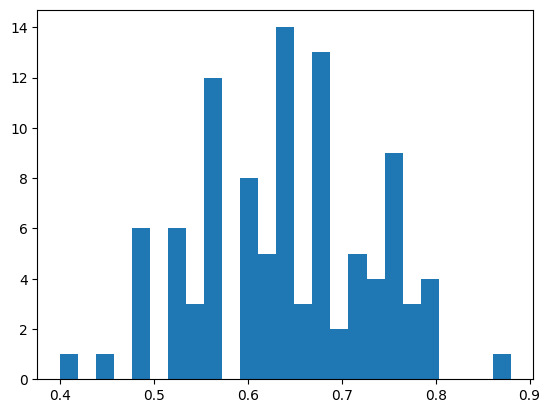

In [144]:
list_fold_acc=[]
list_fold_f1=[]
for train_index, test_index in RSKF.split(X=feat,y=tar): 
    x_tr,x_te=feat.iloc[train_index], feat.iloc[test_index]
    y_tr, y_te=tar.iloc[train_index], tar.iloc[test_index]
        
    y_tr=np.ravel(y_tr.values)
    y_te=np.ravel((y_te.values))
        
    NCA_KNN_pipe=Pipeline([("DataCreate", training.data_creator()),("DataSelect", training.data_selector(force=["X1","X5"])),("scale",StandardScaler()),("KNN",KNeighborsClassifier(n_neighbors=8))])
    NCA_KNN_pipe.fit(X=x_tr,y=y_tr)
    y_p=NCA_KNN_pipe.predict(X=x_te)
    acc=accuracy_score(y_pred=y_p,y_true=y_te)
    f1=f1_score(y_pred=y_p,y_true=y_te)
    list_fold_acc.append(acc)
    list_fold_f1.append(f1)
    
plt.hist(list_fold_acc,bins=25)
plt.show()

I have 21% sureness that above model can beat the 73% line. 

I will rewrite the code so that it can be run in parallel.

In [ ]:
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

## Produce model 

In [146]:
range_nn = range(1, 15 + 1)
range_feat_combin = training.all_combin(eva_out.columns)
print(len(range_feat_combin))

n_split = 5
n_repeats = 20

RSKF = RepeatedStratifiedKFold(n_splits=n_split, random_state=420, n_repeats=n_repeats)

splits = list(RSKF.split(X=feat, y=tar))

def evaluate_combo(list_f_sel_tuple, nn, splits, feat, tar):
    """
    Evaluate one (feature_set, n_neighbors) across all CV folds.
    Returns a dict with all the stats you were collecting.
    """
    list_f_sel = list(list_f_sel_tuple) 
    fold_acc = []
    fold_f1 = []

    for train_index, test_index in splits:
        x_tr, x_te = feat.iloc[train_index], feat.iloc[test_index]
        y_tr, y_te = tar.iloc[train_index], tar.iloc[test_index]

        y_tr = np.ravel(y_tr.values)
        y_te = np.ravel(y_te.values)

        pipe = Pipeline([
            ("DataCreate", training.data_creator()),
            ("DataSelect", training.data_selector(force=list_f_sel)),
            ("scale", StandardScaler()),
            ("KNN", KNeighborsClassifier(n_neighbors=nn)),
        ])

        pipe.fit(X=x_tr, y=y_tr)
        y_p = pipe.predict(X=x_te)

        fold_acc.append(accuracy_score(y_true=y_te, y_pred=y_p))
        fold_f1.append(f1_score(y_true=y_te, y_pred=y_p))

    str_features = ",".join(list_f_sel)
    acc_mean = float(np.mean(fold_acc))
    acc_std  = float(np.std(fold_acc))
    f1_mean  = float(np.mean(fold_f1))
    f1_std   = float(np.std(fold_f1))
    above_73 = float((np.array(fold_acc) >= 0.73).sum() / (len(splits)))

    msg = (
        "_"*20 + "\n"
        + f"Currently used features {str_features}.\n"
        + f"This test has f1 mean {f1_mean} and std {f1_std}.\n"
        + f"Test for {nn} neighbors concluded with acc mean {acc_mean} acc std {acc_std} "
          f"and sureness of beating 73% {above_73}.\n"
        + "_"*20
    )

    return {
        "features": str_features,
        "nn": nn,
        "acc_mean": acc_mean,
        "acc_std": acc_std,
        "f1_mean": f1_mean,
        "f1_std": f1_std,
        "above_73": above_73,
        "log": msg,
    }

jobs = list(itertools.product(range_feat_combin, range_nn))

results = Parallel(n_jobs=-1, backend="loky", verbose=10)(
    delayed(evaluate_combo)(feat_sel, nn, splits, feat, tar)
    for feat_sel, nn in jobs
)

list_feat      = [r["features"] for r in results]
list_nn        = [r["nn"] for r in results]
list_acc_mean  = [r["acc_mean"] for r in results]
list_acc_std   = [r["acc_std"] for r in results]
list_f1_mean   = [r["f1_mean"] for r in results]
list_f1_std    = [r["f1_std"] for r in results]
list_above_73  = [r["above_73"] for r in results]

255


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

In [147]:
df_results = pd.DataFrame({
    "features": list_feat,
    "nn": list_nn,
    "acc_mean": list_acc_mean,
    "acc_std": list_acc_std,
    "f1_mean": list_f1_mean,
    "f1_std": list_f1_std,
    "above_73": list_above_73,
})

In [150]:
df_results.sort_values(by=["above_73"],ascending=False)

,features,nn,acc_mean,acc_std,f1_mean,f1_std,above_73
1485,"X1,X3,X6,above_4",1,0.702754,0.092395,0.739808,0.084133,0.41
1802,"X1,X6,F_w_mean,above_4",3,0.704123,0.083316,0.736048,0.079095,0.40
726,"X1,X6,F_w_mean",7,0.689662,0.097942,0.732151,0.088189,0.39
1474,"X1,X3,X6,F_w_mean",5,0.695415,0.088707,0.725816,0.082690,0.38
724,"X1,X6,F_w_mean",5,0.705277,0.087925,0.746999,0.076984,0.37
...,...,...,...,...,...,...,...
48,X6,4,0.516800,0.086350,0.332990,0.300394,0.00
781,"X1,mean,above_4",2,0.500785,0.089333,0.431312,0.139063,0.00
46,X6,2,0.488062,0.069151,0.218731,0.276586,0.00
1006,"X3,mean,above_4",2,0.495215,0.083525,0.407389,0.126053,0.00


In [149]:
df_results.to_csv("../data/KNN_results_exhaust.csv")

My heart warms when I see above 73 0.41. 

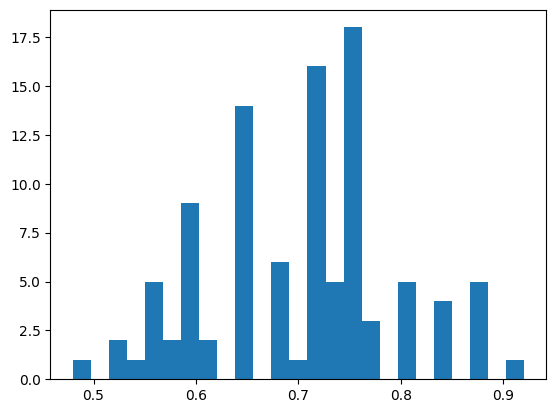

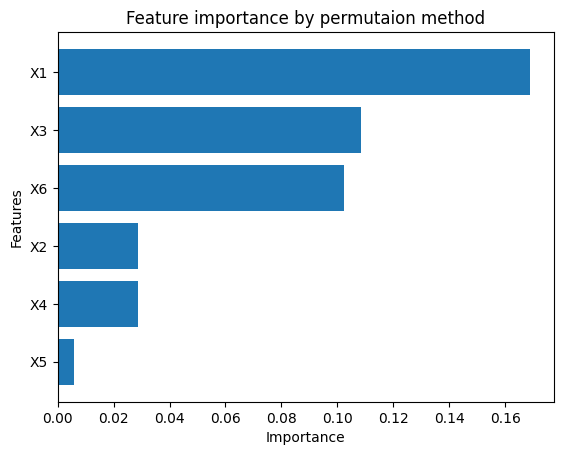

array([[0.27615385, 0.17615385],
       [0.12109231, 0.4266    ]])

In [172]:
list_fold_acc=[]
list_fold_f1=[]
imp_record=None
cmatrix_record=None
splits = list(RSKF.split(X=feat, y=tar))
for train_index, test_index in splits: 
    x_tr,x_te=feat.iloc[train_index], feat.iloc[test_index]
    y_tr, y_te=tar.iloc[train_index], tar.iloc[test_index]
        
    y_tr=np.ravel(y_tr.values)
    y_te=np.ravel((y_te.values))
        
    KNN_pipe=Pipeline([("DataCreate", training.data_creator()),("DataSelect", training.data_selector(force=["X1","X3","X6","above_4"])),("scale",StandardScaler()),("KNN",KNeighborsClassifier(n_neighbors=1))])
    KNN_pipe.fit(X=x_tr,y=y_tr)
    y_p=KNN_pipe.predict(X=x_te)
    acc=accuracy_score(y_pred=y_p,y_true=y_te)
    f1=f1_score(y_pred=y_p,y_true=y_te)
    list_fold_acc.append(acc)
    list_fold_f1.append(f1)
    # with parallel_backend("threading", n_jobs=-1):
    #     with threadpool_limits(limits=1):
    imp=permutation_importance(KNN_pipe,X=x_te.copy(deep=True),y=y_te,scoring="accuracy",n_repeats=30,n_jobs=-1,random_state=420)
    if imp_record is None: 
        imp_record=imp.importances_mean
    else: 
        imp_record=imp_record+imp.importances_mean
    cmatrix=confusion_matrix(y_pred=y_p,y_true=y_te)
    cmatrix=cmatrix/np.sum(cmatrix)
    if cmatrix_record is None: 
        cmatrix_record=cmatrix
    else: 
        cmatrix_record=cmatrix_record+cmatrix
    

plt.hist(list_fold_acc,bins=25)
plt.show()

imp_record=imp_record/len(splits)
imp_sort_index=imp_record.argsort()
plt.barh(feat.columns[imp_sort_index], imp_record[imp_sort_index])
plt.title("Feature importance by permutaion method")
plt.ylabel("Features")
plt.xlabel("Importance")
plt.show()

cmatrix_record=cmatrix_record/len(splits)
cmatrix_record #This is the "Average confusion matrix" 

In [153]:
float((np.array(list_fold_acc) >= 0.73).sum() / (len(splits)))

0.41

That is 41% sureness of beating 73% accuracy. 

X5 literally has lower impact than the two features X2 and X4 that did not appear directly (they still appeared through the manufactured features). 